# Subsystem 1: Landmark extraction

In [7]:
import tensorflow as tf
import numpy as np
# import sklearn as sk
import pandas as pd
import cv2
import os 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt             
import random
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider
import pickle
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt
import time
# from utils import *
# Load the saved model
from tensorflow.keras.models import load_model
from ipywebrtc import CameraStream, ImageRecorder, VideoRecorder
print("Imported correctly ...")


Imported correctly ...


In [2]:
PATH_DATASET_1 = '../../dataset/Dataset_Subsystem_1.csv'
PATH_DATASET_2 = '../../dataset/Dataset_Subsystem_1.csv'
PATH_VIDEOS    = '../../dataset/videos'

In [21]:
###################
# Usefull functions
###################
FRAME_WIDTH       = 640
FRAME_HEIGHT      = 480


def getFrames(path):
    '''
    Args: String.
    Returns: arr: Numpy array containing all frames in video.
    '''
    arr = []
    videocap = cv2.VideoCapture(path)

    if '723/open_palm.webm' in path:
        ret, frame = videocap.read()
        ret, frame = videocap.read()
    else:
        ret, frame = videocap.read()
    while ret:

       #!TODO: Fix landmarks positions of croped videos.
        ret, frame = videocap.read()
        if not ret:
            break

        frame = frame[:FRAME_HEIGHT, :FRAME_WIDTH, :]  # Crop videos to 480x640
        arr.append(frame)

    videocap.release()
    return np.array(arr)

def displayFrame(frame):
    disp = widgets.Image()
    display_image = cv2.imencode('.png', frame)[1].tostring()
    disp.value = display_image
    display(disp)


In [5]:
##########################################
# SUBSYSTEM I: Landmark Extraction dataset
##########################################

# Change below
LOAD_SAVED_DATA = False # Create dataset or load from saved file.

# X1 : dataset in shape (numvids * numframes, 480, 640 ,3 )
LANDMARK_OFFSET_I = 5
FRAME_WIDTH       = 640
FRAME_HEIGHT      = 480

if LOAD_SAVED_DATA:
    X = np.load('data/X_orig_resized_factor_5.npy') # Gray color, scaled by 5 shape: (96, 128, 1)
    Y = np.load('data/Y_orig_resized_factor_5.npy') 

    print(f"Training datapoint shape: X_train.shape:{X.shape}. \tType: {X.dtype}")
    print(f"Training labels shape\t: y_train.shape:{Y.shape}.  \t\tType: {Y.dtype}")

else:
    # Importing dataset (dtype: string and uint32)
    dset_1 = pd.read_csv(PATH_DATASET_1, sep=",", dtype={'ID': str, 'source': str, 'camera_facing_side': str, 'gesture': str})

    # Extracting landmarks
    Y1features = dset_1.columns[LANDMARK_OFFSET_I:]
    Y1         = dset_1[Y1features].to_numpy()

    # Ignore landmarks (set to 0) outside heigh 480 and width 640
    index_outside_width = [Y1[:,::2] > FRAME_WIDTH]
    Y1[:,::2][index_outside_width] = np.zeros(Y1[:,::2][index_outside_width].shape)

    index_outside_width = [Y1[:,1::2] > FRAME_HEIGHT]
    Y1[:,1::2][index_outside_width] = np.zeros(Y1[:,1::2][index_outside_width].shape)
    

    # Construct path to every video base on ID + source.
    num_samples  = dset_1["ID"].size                          # Num of samples (# videos * frames).
    paths_arr    = dset_1["source"].drop_duplicates() # Retrieve ID and source columns.
    paths_full   = [os.path.join(PATH_VIDEOS, p) for p in paths_arr.values]

    # Compute number of frames per video. (cv2.CAP_PROP_FRAME_COUNT does not work)
    idx_frames   = np.append(paths_arr.index.to_numpy(), num_samples) # Contains comulative number of frames.
    num_frames   = idx_frames[1:] - idx_frames[0:-1]                  # Contains number of frames of each video. 
    num_videos   = len(num_frames)                                    # Expecting 10 videos.

    # Print debugging info
    print(f"Num samples found\t: {num_samples}")
    print(f"Num videos found\t: {num_videos}")

    X1arr = [getFrames(path) for path in paths_full]
    
    print("Done")
    #!TODO: Fixed landmark positions of croped videos.

Num samples found	: 11996
Num videos found	: 60
Done


In [ ]:
## Preprocessing data: Load data, resize, split into train test sets. save

(11996, 480, 640, 3)


In [ ]:
# Resize frames and landmarks by factor 5
frames_resized = []
for frame in tqdm(X_orig):
    resized = cv2.resize(frame, (96,128), interpolation = cv2.INTER_AREA) 
    arr.append(resized)
    
frames_resized = np.array(frames_resized).astype(np.float32)
landmarks_resized = Y_orig.astype(np.float32)/5.0 # Scaled landmarks by factor 5.


np.save('data/original_frames_resized.npy', frames_resized)
np.save('data/original_landmarks_resized.npy', landmarks_resized)
print("saved.")

print(arr.shape)

In [ ]:
# Save resized frames
np.save('data/frames_resized.npy', frames_resized)

In [23]:
X = np.load('data/original_frames_resized.npy')
y = np.load('data/original_landmarks_resized.npy')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape)

(9596, 128, 96, 3)


# PART 2: TRAIN MODEL

(9596, 128, 96, 3)
(2400, 128, 96, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


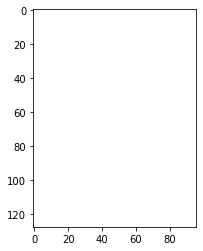

In [26]:
# Load frames: Croped frames showing only hands. Shape: (384, 384, 3)
import numpy as np
Xtrain = np.load('data/Xtrain.npy')
Xtest  = np.load('data/Xtest.npy')
Ytrain = np.load('data/Ytrain.npy')
Ytest  = np.load('data/Ytest.npy')

print(Xtrain.shape)
print(Xtest.shape)

displayFrame(Xtrain[0])

In [30]:
Xtrain_norm = []

for frame in Xtrain:
    shaped = cv2.resize(frame, (96,128), interpolation =cv2.INTER_AREA)
    Xtrain_norm.append(shaped)

Xtrain_norm = np.array(Xtrain_norm)
Xtrain_norm.shape

(9596, 128, 96, 3)

In [31]:
Xtest_norm = []

for frame in Xtest:
    shaped = cv2.resize(frame, (96,128), interpolation =cv2.INTER_AREA)
    Xtest_norm.append(shaped)

Xtest_norm = np.array(Xtest_norm)
Xtest_norm.shape

(2400, 128, 96, 3)

# TEST TRAINED MODEL

In [25]:
def displayFrame(frame, landmarks = None):
    frame = frame.reshape(128,96,3)
    if landmarks is not None:  
        frame = frame.reshape(128,96,3)
        landmarks = landmarks.reshape(2,5,4,2) # (2 hand sides, 5 fingers, 4 landmarks, 2 coordinates)
        for side in landmarks:
            root = side[0][0]
            for finger in side:
                for lmarks in finger:
                    cv2.circle(frame, (lmarks[0], lmarks[1]), 1, color=(0,255,0))

    plt.imshow(frame)
    plt.show()


In [5]:
# Load train test datasets
import numpy as np

X_train = np.load('data/original_Xtrain_resized.npy')
X_test = np.load('data/original_Xtest_resized.npy')
Y_train = np.load('data/original_Ytrain.npy')
Y_test = np.load('data/original_Ytest.npy')


X_train = X_train.astype(np.float32)/255.0
X_test = X_test.astype(np.float32)/255.0
Y_train = Y_train.astype(np.float32)/5
Y_test = Y_test.astype(np.float32)/5

print(X_train.shape)

(9596, 128, 96, 3)


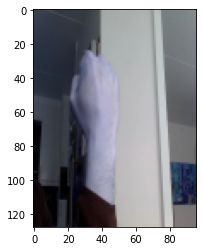

In [10]:
displayFrame(X_train[0])

In [6]:
from tensorflow.keras.models import load_model

model = load_model('checkpoint_2.hdf5')

model.evaluate(X_test, Y_test)

75/75 [==============================] - 13s 171ms/step - loss: 2.4209 - accuracy: 0.9025


[2.420933246612549, 0.9024999737739563]

In [10]:
predict = model.predict(X_test[0:1])

In [19]:
X_train.shape

(9596, 128, 96, 3)

In [9]:
Y_test[0:1]

array([[ 93.4,  88.6,  74.8,  67.4,  70. ,  57.6,  63.6,  47. ,  84.4,
         50. ,  83. ,  38.6,  80.8,  26. ,  81.6,  15.2,  97.4,  50.6,
        101.4,  37.6, 103. ,  25.8, 106.6,  11. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ,   0. , 107. ,  57.2, 102.8,  71.4,  98.8,  81. ,
        120.2,  72.6, 114.8,  69. , 110.4,  77.2, 104.8,  87.4]],
      dtype=float32)

In [ ]:
import cv2
 
capture = cv2.VideoCapture(0)
 
while(True):
    ret, frame = capture.read()
    # cv2.imshow('video', frame)
    displayFrame(frame)
    
    if cv2.waitKey(1) == 27:
        break
 
capture.release()
cv2.destroyAllWindows()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


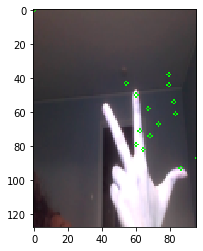

In [18]:
# Show random frame with landmarks
import random 
m = X_train.shape[0] # Num samples
rand_i = random.choice(range(0, m-1))

random_frame = X_train[rand_i]
random_landmark = Y_train[rand_i]

displayFrame(random_frame, random_landmark)

In [26]:
np.min(X_train)

0.0

In [7]:
#

In [6]:
# Prepare model
epochs = 100
batch_size = 64
checkpoint_file = 'checkpoint.hdf5'
model_file_name = 'model.h5'

In [8]:
#

In [12]:
# TRAIN MODEL
# model = CNN_model()
model = load_model(checkpoint_file)
hist = History()
checkpointer = ModelCheckpoint(filepath=checkpoint_file, verbose=1, save_best_only=True)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
# model_fit = model.fit(X_train, Y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)
model_fit = model.fit(X_train, Y_train,validation_data = (X_test, Y_test), epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)

model.save(model_file_name)


Epoch 1/100
149/150 [============================>.] - ETA: 0s - loss: 10.8499 - accuracy: 0.7542
Epoch 00001: val_loss improved from inf to 2.02012, saving model to checkpoint.hdf5
150/150 [==============================] - 8s 50ms/step - loss: 10.8408 - accuracy: 0.7542 - val_loss: 2.0201 - val_accuracy: 0.9133
Epoch 2/100
149/150 [============================>.] - ETA: 0s - loss: 10.4582 - accuracy: 0.7473
Epoch 00002: val_loss did not improve from 2.02012
150/150 [==============================] - 7s 47ms/step - loss: 10.4730 - accuracy: 0.7472 - val_loss: 2.2006 - val_accuracy: 0.9175
Epoch 3/100
149/150 [============================>.] - ETA: 0s - loss: 10.1943 - accuracy: 0.7517
Epoch 00003: val_loss did not improve from 2.02012
150/150 [==============================] - 7s 47ms/step - loss: 10.1976 - accuracy: 0.7521 - val_loss: 2.2222 - val_accuracy: 0.9204
Epoch 4/100
149/150 [============================>.] - ETA: 0s - loss: 10.3180 - accuracy: 0.7485
Epoch 00004: val_loss d

KeyboardInterrupt: 

In [7]:
model = load_model(checkpoint_file)  # <-- Saved model path
test_lost, test_acc = model.evaluate(X_test, Y_test)
print(f"Test accuracy: {test_acc}")

75/75 [==============================] - 1s 9ms/step - loss: 1.1320 - accuracy: 0.9396
Test accuracy: 0.9395833611488342


In [33]:
random_frame = X_test[0:1]
trueframe = Y_test[0:1]
model.predict(random_frame)

array([[ 9.58682251e+01, -5.99498786e-02,  7.60636520e+01,
        -6.74788281e-02,  7.16456070e+01, -4.65026423e-02,
         6.46869278e+01,  6.75902218e-02,  8.73178024e+01,
        -8.62959400e-02,  8.35565338e+01, -2.95184013e-02,
         8.22618790e+01,  6.66362196e-02,  8.36525803e+01,
         4.36869785e-02,  9.97952271e+01, -2.93491092e-02,
         1.02220856e+02, -1.25128925e-02,  1.03656799e+02,
         9.36501101e-03,  1.06642715e+02,  2.12274920e-02,
        -3.68821144e-01,  4.15595211e-02, -1.49874210e-01,
        -3.53442803e-02,  1.71442032e-02, -2.16449425e-02,
         1.09512329e-01,  4.06835526e-02,  8.93605232e-01,
         1.12054385e-02,  6.03652954e-01,  3.55035886e-02,
         7.82325268e-01, -6.52201772e-02,  9.25934792e-01,
         3.14368941e-02,  4.53571320e-01, -5.25663495e-02,
        -9.07608032e-01,  1.31590683e-02, -6.16815567e-01,
         1.18123561e-01, -4.09469604e-01,  5.34928329e-02,
        -8.75492096e-02,  5.55662028e-02,  9.18901443e-0

In [35]:
trueframe.flatten()

array([9.3400002e+01, 2.8841145e-04, 7.4800003e+01, 2.1940104e-04,
       7.0000000e+01, 1.8749999e-04, 6.3599998e+01, 1.5299479e-04,
       8.4400002e+01, 1.6276042e-04, 8.3000000e+01, 1.2565104e-04,
       8.0800003e+01, 8.4635416e-05, 8.1599998e+01, 4.9479168e-05,
       9.7400002e+01, 1.6471354e-04, 1.0140000e+02, 1.2239582e-04,
       1.0300000e+02, 8.3984371e-05, 1.0660000e+02, 3.5807294e-05,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [22]:

model.evaluate(X_train[0:1], Y_train[0:1])

1/1 [==============================] - 0s 1ms/step - loss: 0.1856 - accuracy: 1.0000


[0.1856464445590973, 1.0]

In [42]:
#Get 
def getLandmark(frame):
    '''
    Frame must be gray/scaled to (98,124) and normalized.
    
    '''
    frame = frame.reshape(1,96,128,1)
    prediction = model.predict(frame)
    print(prediction)
    prediction[:,::2]  = np.squeeze(prediction)[:,::2]*128 + 128  # 
    prediction[:,1::2] = np.squeeze(prediction)[:,1::2]*98 + 98  # 
    
    return prediction


In [26]:
model = load_model(model_file_name)
pred = model.predict(X_test[0].reshape(1,96,128,1), Y_test[0])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [30]:
Y_test

array([[0.7296875 , 0.92291665, 0.584375  , ..., 0.8041666 , 0.81875   ,
        0.91041666],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.48749998, 0.7296875 ,
        0.42499998],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.6234375 , 0.9791667 , 0.53125   , ..., 0.8666666 , 0.6796875 ,
        0.9145834 ],
       [0.8734375 , 0.63958335, 0.        , ..., 0.4416667 , 0.88125   ,
        0.46666667]], dtype=float32)

In [45]:
# Test with random frame
test = X_test[0]
landmarks = getLandmark(test)
landmarks

[[-0.31811047 -0.10509384 -0.42613074 -0.31619245 -0.4701534  -0.41363835
  -0.52288574 -0.5165466  -0.3504058  -0.4940247  -0.36612058 -0.61309147
  -0.37874705 -0.7161057  -0.38495392 -0.8215599  -0.26327467 -0.48259965
  -0.24091053 -0.60689276 -0.22337133 -0.71453774 -0.20097625 -0.83416545
  -1.0049634  -1.0073214  -1.004494   -1.0095537  -1.0030193  -1.0125029
  -1.0019654  -1.0176463  -1.0127659  -0.9984679  -1.0032864  -1.0022572
  -1.0017043  -1.0049176  -1.0003883  -1.0071337  -0.99230087 -0.99154377
  -1.0010561  -0.9962868  -0.9854815  -0.9735563  -0.9902699  -0.98658043
  -0.9973302  -1.001126   -0.98486054 -0.9804981  -0.9969277  -1.0147069
  -0.98600346 -0.98581284 -1.0001308  -0.99582565 -0.9861656  -0.96937984
  -0.9872987  -0.9811785  -0.9941625  -0.9846091  -0.99459165 -0.9913281
  -0.19315791 -0.39899796 -0.21609753 -0.2643615  -0.23609447 -0.17668062
  -0.11789811 -0.25705376 -0.13280201 -0.29976073 -0.15863419 -0.1958285
  -0.19300282 -0.13608783]]


IndexError: too many indices for array

In [34]:
np.max(Y_train)

1.0104166

In [ ]:
def drawLandmarks(frame, landmarks):
    

In [28]:
camera = CameraStream(constraints=
                      {'facing_mode': 'user',
                       'audio': False,
                       'video': { 'width': 640, 'height': 480 }
                       })
camera

CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 640, 'height': 480}})

In [4]:
recorder = ImageRecorder(stream=camera)
recorder

ImageRecorder(image=Image(value=b''), stream=CameraStream(constraints={'facing_mode': 'user', 'audio': False, …

In [29]:
camera.close()

In [30]:
snapshot = recorder.image.value
snapshot = np.frombuffer(snapshot, dtype=np.uint8)
snapshot = cv2.imdecode(snapshot, cv2.IMREAD_COLOR)
snapshot.shape

(2, 2, 3)

In [ ]:

def detect_points(face_img):
    me  = np.array(face_img)/255
    x_test = np.expand_dims(me, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = model.predict(x_test)
    label_points = (np.squeeze(y_test)*48)+48 
    
    return label_points
    
# Load haarcascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
dimensions = (96, 96)

# Enter the path to your test image
img = cv2.imread('you_test_image.jpg')

default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
# faces = face_cascade.detectMultiScale(gray_img, 4, 6)

faces_img = np.copy(gray_img)

plt.rcParams["axes.grid"] = False


all_x_cords = []
all_y_cords = []

for i, (x,y,w,h) in enumerate(faces):
    
    h += 10
    w += 10
    x -= 5
    y -= 5
    
    just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
    cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)
    
    scale_val_x = w/96
    scale_val_y = h/96
    
    label_point = detect_points(just_face)
    all_x_cords.append((label_point[::2]*scale_val_x)+x)
    all_y_cords.append((label_point[1::2]*scale_val_y)+y)
   
   
    plt.imshow(just_face, cmap='gray')
    plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=5)
    plt.show()
    
    
plt.imshow(default_img)    
plt.plot(all_x_cords, all_y_cords, 'wo',  markersize=3)
plt.show()


